# Imports

In [1]:
import matplotlib.pyplot as plt
import optuna
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from src.preprocessing import preprocess_data
from src.utils.compute_metrics import compute_and_store_metrics
from src.utils.confusion_matrix import plot_confusion_matrix
from src.utils.load_data import load_data


# Load Data

In [2]:
X, y = preprocess_data(load_data())

# Model

## Base Logistic Regression

In [3]:
## Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [4]:
## Model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[
    :, 1
]  # Probability estimates for the positive class (default)

In [5]:
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)

### Evaluation

In [6]:
classification_rep = classification_report(y_test, y_pred)
clf_matrix = confusion_matrix(y_test, y_pred)

/home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0

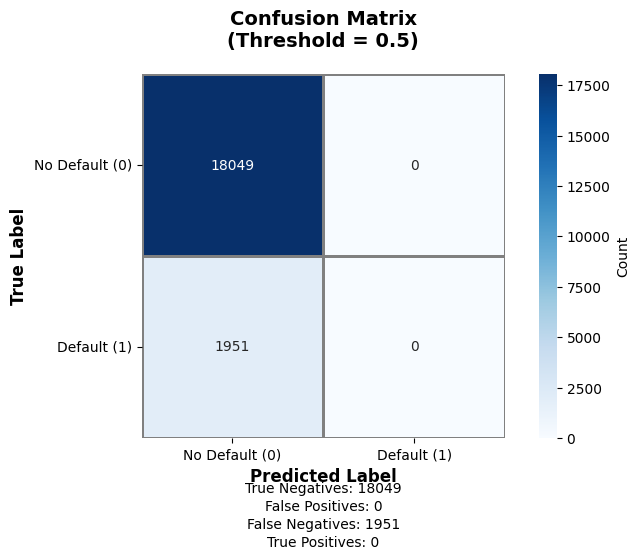


Key Metrics Summary:
Accuracy:  0.9024 (90.25%)
Precision: 0.0000 (0.00%)
Recall:    0.0000 (0.00%)
F1-Score:  0.0000 (0.00%)


In [7]:
# Create a beautiful confusion matrix visualization
fig, ax = plt.subplots(figsize=(8, 6))

# Create heatmap
sns.heatmap(
    clf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar_kws={"label": "Count"},
    square=True,
    linewidths=1,
    linecolor="gray",
    ax=ax,
)

# Customize labels
ax.set_xlabel("Predicted Label", fontsize=12, fontweight="bold")
ax.set_ylabel("True Label", fontsize=12, fontweight="bold")
ax.set_title(
    "Confusion Matrix\n(Threshold = 0.5)", fontsize=14, fontweight="bold", pad=20
)

# Set tick labels
ax.set_xticklabels(["No Default (0)", "Default (1)"])
ax.set_yticklabels(["No Default (0)", "Default (1)"], rotation=0)

# Add text annotations for clarity
tn, fp, fn, tp = clf_matrix.ravel()
ax.text(
    0.5,
    -0.15,
    f"True Negatives: {tn}",
    ha="center",
    transform=ax.transAxes,
    fontsize=10,
)
ax.text(
    0.5,
    -0.20,
    f"False Positives: {fp}",
    ha="center",
    transform=ax.transAxes,
    fontsize=10,
)
ax.text(
    0.5,
    -0.25,
    f"False Negatives: {fn}",
    ha="center",
    transform=ax.transAxes,
    fontsize=10,
)
ax.text(
    0.5,
    -0.30,
    f"True Positives: {tp}",
    ha="center",
    transform=ax.transAxes,
    fontsize=10,
)

plt.tight_layout()
plt.show()

# Calculate and display key metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nKey Metrics Summary:")
print(f"{'=' * 40}")
print(f"Accuracy:  {accuracy:.4f} ({accuracy * 100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision * 100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall * 100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1 * 100:.2f}%)")

## Hyperparameter fine-tuning (Optuna)

In [8]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    C = trial.suggest_float("C", 1e-4, 1e2, log=True)  # Regularization strength
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
    solver = trial.suggest_categorical("solver", ["liblinear", "saga"])
    max_iter = trial.suggest_int("max_iter", 100, 1000)
    threshold = trial.suggest_float("threshold", 0.1, 0.9)

    # Handle solver-penalty compatibility
    if penalty == "l1" and solver not in ["liblinear", "saga"]:
        solver = "liblinear"
    elif penalty == "elasticnet":
        solver = "saga"
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
    else:
        l1_ratio = None

    # Create and train the model
    if penalty == "elasticnet":
        model = LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            max_iter=max_iter,
            l1_ratio=l1_ratio,
            random_state=42,
        )
    else:
        model = LogisticRegression(
            C=C, penalty=penalty, solver=solver, max_iter=max_iter, random_state=42
        )

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[
        :, 1
    ]  # Probability estimates for the positive class (default)
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate F1-score (or any other metric you prefer)
    from sklearn.metrics import f1_score

    score = f1_score(y_test, y_pred)

    return score


# Create and run the study
study = optuna.create_study(direction="maximize")  # We want to maximize F1-score
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n" + "=" * 60)
print("BEST HYPERPARAMETERS")
print("=" * 60)
print(f"Best F1-Score: {study.best_value:.4f}")
print(f"\nBest Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-10-15 14:42:14,868] A new study created in memory with name: no-name-486aa908-a445-4481-bdd5-ce03e14d7afa


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-15 14:42:15,236] Trial 0 finished with value: 0.2664652567975831 and parameters: {'C': 0.020414915710910878, 'penalty': 'l2', 'solver': 'saga', 'max_iter': 939, 'threshold': 0.11185800883869829}. Best is trial 0 with value: 0.2664652567975831.
[I 2025-10-15 14:42:15,584] Trial 1 finished with value: 0.0 and parameters: {'C': 0.0013703120953388137, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 803, 'threshold': 0.4870273308437191}. Best is trial 0 with value: 0.2664652567975831.
[I 2025-10-15 14:42:15,584] Trial 1 finished with value: 0.0 and parameters: {'C': 0.0013703120953388137, 'penalty': 'l1', 'solver': 'saga', 'max_iter': 803, 'threshold': 0.4870273308437191}. Best is trial 0 with value: 0.2664652567975831.
[I 2025-10-15 14:42:16,150] Trial 2 finished with value: 0.0 and parameters: {'C': 0.8006655342522173, 'penalty': 'elasticnet', 'solver': 'saga', 'max_iter': 818, 'threshold': 0.625777659040033, 'l1_ratio': 0.12108895437800982}. Best is trial 0 with value: 0.266465

### Optimized Model Evaluation

In [9]:
# Train the final model with best parameters
best_params = study.best_params

if best_params.get("penalty") == "elasticnet":
    optimized_model = LogisticRegression(
        C=best_params["C"],
        penalty=best_params["penalty"],
        solver=best_params["solver"],
        max_iter=best_params["max_iter"],
        l1_ratio=best_params.get("l1_ratio"),
        class_weight="balanced",
        random_state=42,
    )
else:
    optimized_model = LogisticRegression(
        C=best_params["C"],
        penalty=best_params["penalty"],
        solver=best_params["solver"],
        max_iter=best_params["max_iter"],
        class_weight="balanced",
        random_state=42,
    )

optimized_model.fit(X_train, y_train)
y_pred_proba_optimized = optimized_model.predict_proba(X_test)[:, 1]
y_pred_optimized = (y_pred_proba_optimized >= best_params["threshold"]).astype(int)

print("✅ Optimized model trained successfully!")

✅ Optimized model trained successfully!


📈 Model Comparison:
   Metric  Base Model  Optimized Model  Improvement
 Accuracy     0.90245         0.239150        -73.5
Precision     0.00000         0.112287          inf
   Recall     0.00000         0.984623          inf
 F1-Score     0.00000         0.201585          inf


/home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


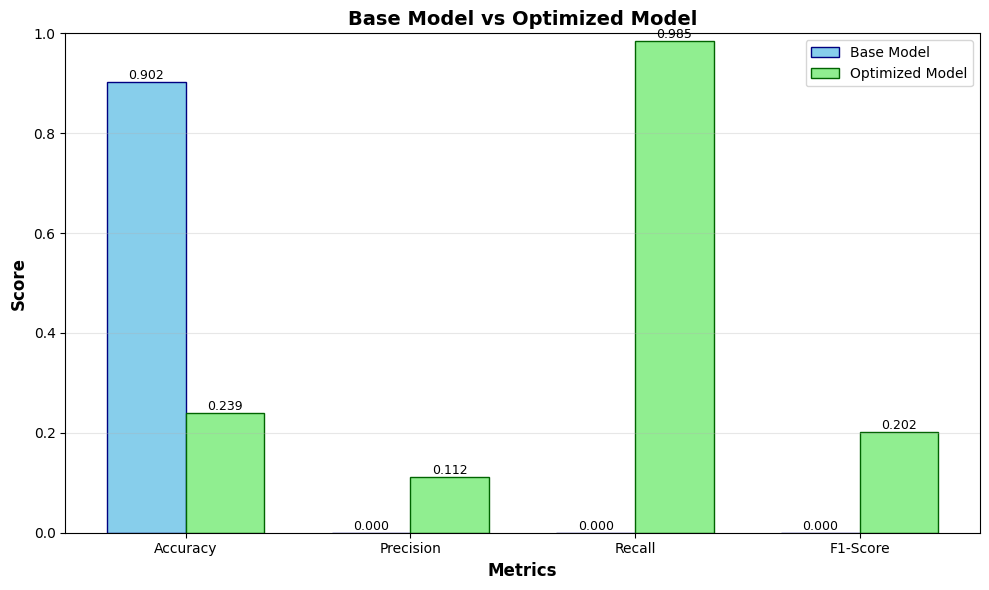

In [10]:
# Compare base model vs optimized model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

comparison_df = pd.DataFrame(
    {
        "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
        "Base Model": [
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred),
            f1_score(y_test, y_pred),
        ],
        "Optimized Model": [
            accuracy_score(y_test, y_pred_optimized),
            precision_score(y_test, y_pred_optimized),
            recall_score(y_test, y_pred_optimized),
            f1_score(y_test, y_pred_optimized),
        ],
    }
)

comparison_df["Improvement"] = (
    (comparison_df["Optimized Model"] - comparison_df["Base Model"])
    / comparison_df["Base Model"]
    * 100
).round(2)

print("📈 Model Comparison:")
print("=" * 70)
print(comparison_df.to_string(index=False))
print("=" * 70)

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(comparison_df))
width = 0.35

bars1 = ax.bar(
    [i - width / 2 for i in x],
    comparison_df["Base Model"],
    width,
    label="Base Model",
    color="skyblue",
    edgecolor="navy",
)
bars2 = ax.bar(
    [i + width / 2 for i in x],
    comparison_df["Optimized Model"],
    width,
    label="Optimized Model",
    color="lightgreen",
    edgecolor="darkgreen",
)

ax.set_xlabel("Metrics", fontsize=12, fontweight="bold")
ax.set_ylabel("Score", fontsize=12, fontweight="bold")
ax.set_title("Base Model vs Optimized Model", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(comparison_df["Metric"])
ax.legend()
ax.grid(True, alpha=0.3, axis="y")
ax.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

plt.tight_layout()
plt.show()

### Model Comparison

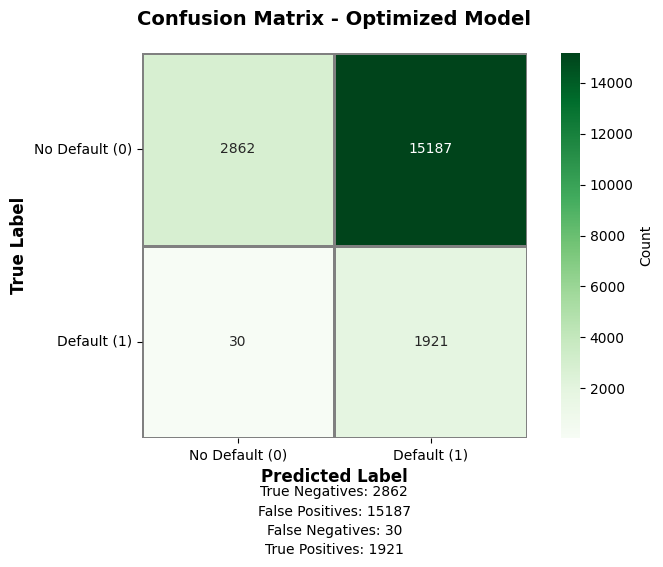


Model Metrics:
Accuracy:  0.2392 (23.91%)
Precision: 0.1123 (11.23%)
Recall:    0.9846 (98.46%)
F1-Score:  0.2016 (20.16%)


In [11]:
plot_confusion_matrix(y_test, y_pred_optimized)

### Train Final Model with Best Parameters

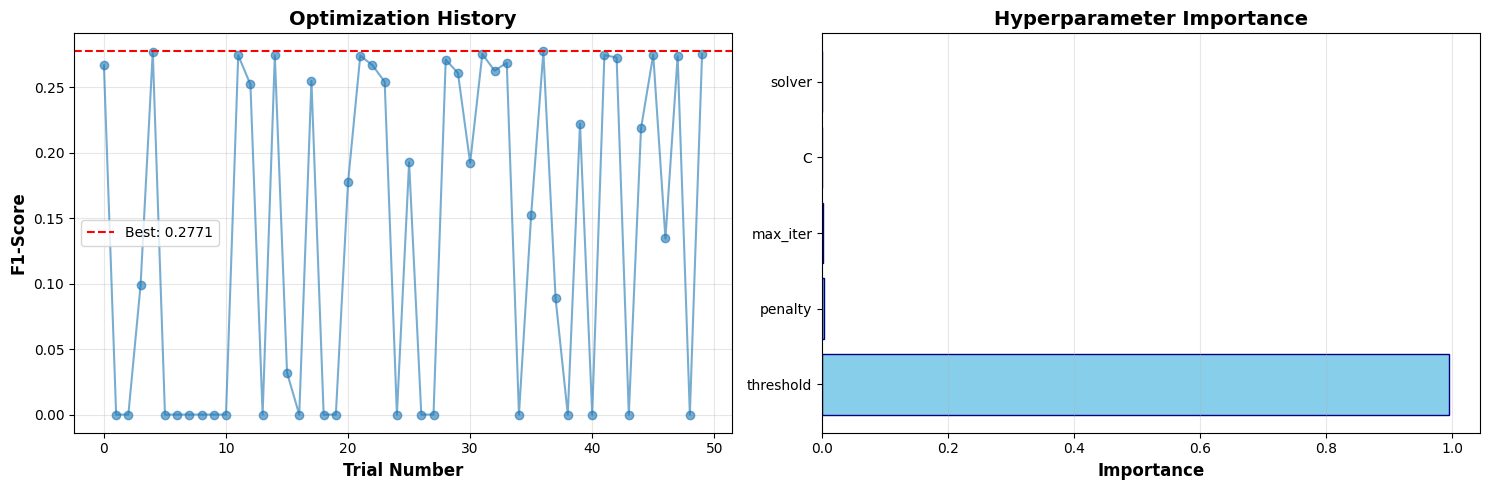

In [12]:
# Plot optimization history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Optimization History
trials_df = study.trials_dataframe()
axes[0].plot(trials_df.index, trials_df["value"], marker="o", linestyle="-", alpha=0.6)
axes[0].axhline(
    y=study.best_value, color="r", linestyle="--", label=f"Best: {study.best_value:.4f}"
)
axes[0].set_xlabel("Trial Number", fontsize=12, fontweight="bold")
axes[0].set_ylabel("F1-Score", fontsize=12, fontweight="bold")
axes[0].set_title("Optimization History", fontsize=14, fontweight="bold")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Parameter Importance
from optuna.importance import get_param_importances

importances = get_param_importances(study)
params = list(importances.keys())
values = list(importances.values())

axes[1].barh(params, values, color="skyblue", edgecolor="navy")
axes[1].set_xlabel("Importance", fontsize=12, fontweight="bold")
axes[1].set_title("Hyperparameter Importance", fontsize=14, fontweight="bold")
axes[1].grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.show()

Logstic Regression model not good to predict default (low F1-score).

In [13]:
compute_and_store_metrics(y_test, y_pred_optimized, model_name="Logistic Regression")